# Outline
- [Part 1:  import packages](#1) 
    
    
- [Part 2:  prepare functions](#2)

    - [2.1  create train & validation generators function](#2.1)
    - [2.2  build model function](#2.2)
    - [2.3  learning rate scadular](#2.3)
    - [2.4  model training function](#2.4)
    - [2.5  load test data](#2.5)
    - [2.6  draw training graph function](#2.6)
    - [2.7  draw confusion_matrix function](#2.7)
    - [2.8  print classification report function](#2.8)
    
    
- [Part 3:  train the model on the original data](#3)

    - [3.1  model on imbalanced data](#3.1)
        - [3.1.1  model architecture](#3.1.1)
        - [3.1.2  train the model](#3.1.2)
        - [3.1.3  train results](#3.1.3)
        - [3.1.4  test results](#3.1.4)
        
    - [3.2  model on oversampled data](#3.2)
        - [3.2.1  model architecture](#3.2.1)
        - [3.2.2  train the model](#3.2.2)
        - [3.2.3  train results](#3.2.3)
        - [3.2.4  test results](#3.2.4)
        
    - [3.3  model on undersampled data](#3.3)
        - [3.3.1  model architecture](#3.3.1)
        - [3.3.2  train the model](#3.3.2)
        - [3.3.3  train results](#3.3.3)
        - [3.3.4  test results](#3.3.4)

- [Part 4:  train the model on the paper preprocessed data](#4)

    - [4.1  model on imbalanced data](#4.1)
        - [4.1.1  model architecture](#4.1.1)
        - [4.1.2  train the model](#4.1.2)
        - [4.1.3  train results](#4.1.3)
        - [4.1.4  test results](#4.1.4)
        
    - [4.2  model on oversampled data](#4.2)
        - [4.2.1  model architecture](#4.2.1)
        - [4.2.2  train the model](#4.2.2)
        - [4.2.3  train results](#4.2.3)
        - [4.2.4  test results](#4.2.4)
        
    - [4.3  model on undersampled data](#4.3)
        - [4.3.1  model architecture](#4.3.1)
        - [4.3.2  train the model](#4.3.2)
        - [4.3.3  train results](#4.3.3)
        - [4.3.4  test results](#4.3.4)



<a name="1"></a>
##  <span style="color:blue"> **import packages** </span>

In [2]:
import numpy as np
from tqdm import tqdm
import glob
import pickle
import math
import gc
#for model
import tensorflow as tf
from tensorflow.math import exp
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, BatchNormalization , Dropout,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.test import is_built_with_cuda
from tensorflow.keras.models import load_model

In [3]:
#for model evaluation and visualization
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
# to avoid gpu errors
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
is_built_with_cuda()

True

<a name="2"></a>
##  <span style="color:blue"> **prepare functions** </span>

<a name="2.1"></a>

In [6]:
# build train & validation generator 
def create_generators(train_path):
    train_datagen  = ImageDataGenerator(
                                        rescale=1 / 255.0,
                                        rotation_range=30,
                                        zoom_range = 0.2,
                                        validation_split=0.2)

    train_generator = train_datagen.flow_from_directory(
        directory=train_path,
        target_size=(224, 224),
        batch_size=16,
        class_mode="binary",
        subset='training',
        shuffle=True,
    )

    valid_datagen=ImageDataGenerator(
                                    rescale=1 / 255.0,
                                    validation_split=0.2)

    valid_generator = valid_datagen.flow_from_directory(
        directory=train_path,
        target_size=(224, 224),
        batch_size=16,
        class_mode="binary",
        subset='validation',
    )
    return train_generator ,valid_generator

<a name="2.2"></a>

In [7]:
def build_model():
    model = ResNet50(include_top=True ,input_shape=(224,224,3) , weights="imagenet")
    for layer in model.layers:
        layer.trainable=True
    base_input= model.layers[0].input
    base_output= model.layers[-1].output
#     l =Dense(units = 512 ,activation='relu')(base_output)
    l=BatchNormalization()(base_output)
    l=Dropout(0.5)(l)
    
    final_output= Dense(units = 1 ,activation='sigmoid')(l)
    
    new_model= Model(inputs=base_input,outputs= final_output)


    return new_model

<a name="2.3"></a>

In [8]:
EPOCHS = 40

LEARNING_RATE = 3e-5
LR_START = 1e-8
LR_MIN = 1e-8
LR_MAX = LEARNING_RATE

LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
N_CYCLES = .5
 

In [9]:
# scadular for modifing learning rate during training
def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        progress = (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) / (EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
        lr = LR_MAX * (0.5 * (1.0 + tf.math.cos(math.pi * N_CYCLES * 2.0 * progress)))
        if LR_MIN is not None:
            lr = tf.math.maximum(LR_MIN, lr)
            
    return lr

# def scheduler(epoch, lr):
#     if epoch %2 != 0:
#          return lr
#     else:
#          return lr* tf.math.exp(-0.1)
# #         

<a name="2.4"></a>

In [10]:
def train_model(model, train_generator, valid_generator):
    
    checkpoint_filepath = './resnet50/checkpoint'
    model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=0)

    callback = [LearningRateScheduler(lrfn),model_checkpoint_callback]
    model.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])
    history= model.fit(train_generator ,validation_data=(valid_generator) ,epochs=EPOCHS,callbacks=callback)
    return history

<a name="2.5"></a>

In [5]:
x_test=pickle.load(open("D:/projects data/dataset/C-NMC_Leukemia/final/x_test.pkl", 'rb'))
y_test=pickle.load(open('D:/projects data/dataset/C-NMC_Leukemia/final/y_test.pkl', 'rb'))

In [20]:
# for preprocessing 1
x_test=pickle.load(open("D:/projects data/dataset/C-NMC_Leukemia/final/x_test_pre1.pkl", 'rb'))
y_test=pickle.load(open('D:/projects data/dataset/C-NMC_Leukemia/final/y_test.pkl', 'rb'))

<a name="2.6"></a>

In [11]:
# graph of (train & validation) (accuracy & loss) per training epochs
def draw_train_graph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']


    import matplotlib.pyplot as plt

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

<a name="2.7"></a>

In [6]:
# draw the confusion_matrix for testing data 
def draw_confusion_matrix(model,x_test,y_test):

    y_test_predict=model.predict(x_test)
    y_test_predict = np.around(y_test_predict)
    #Generate the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_test_predict)


    plt.figure(figsize = (10,7))
    sn.heatmap(cf_matrix, annot=True,cmap='Blues', fmt='g')
    return y_test_predict

<a name="2.8"></a>

In [7]:
# print the classification_report for testing data 
def print_classification_report(y_test,  y_test_predict):
    target_names = ['abnormal', 'normal']
    print(classification_report(y_test,  y_test_predict,target_names=target_names))

<a name="3"></a>
##  <span style="color:blue"> **train the model on the original data** </span>

<a name="3.1"></a>

### on original imbalanced data

<a name="3.1"></a>

In [8]:
train_datagen  = ImageDataGenerator(
                                    rescale=1 / 255.0,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    zoom_range = 0.2,

                                    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    subset='training',
    shuffle=True,
)

valid_datagen=ImageDataGenerator(rescale=1 / 255.0,
                                validation_split=0.2)

valid_generator = valid_datagen.flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    subset='validation',
    shuffle=True,
)

Found 8017 images belonging to 2 classes.
Found 2003 images belonging to 2 classes.


In [15]:
train_generator,valid_generator = create_generators(train_path)

Found 9019 images belonging to 2 classes.
Found 1001 images belonging to 2 classes.


<a name="2"></a>

### build the model

In [24]:
model1 =build_model()
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

<a name="2.1"></a>

### model complie & train

In [25]:
history=train_model(model1,train_generator,valid_generator)

Epoch 1/40
564/564 [==============================] - 123s 211ms/step - loss: 0.6985 - accuracy: 0.4855 - val_loss: 0.8412 - val_accuracy: 0.3297 - lr: 1.0000e-08
Epoch 2/40
564/564 [==============================] - 119s 210ms/step - loss: 0.5178 - accuracy: 0.8018 - val_loss: 0.5712 - val_accuracy: 0.7333 - lr: 1.0007e-05
Epoch 3/40
564/564 [==============================] - 118s 209ms/step - loss: 0.3579 - accuracy: 0.8856 - val_loss: 0.4815 - val_accuracy: 0.7862 - lr: 2.0003e-05
Epoch 4/40
564/564 [==============================] - 119s 211ms/step - loss: 0.2904 - accuracy: 0.9076 - val_loss: 0.5200 - val_accuracy: 0.7682 - lr: 3.0000e-05
Epoch 5/40
564/564 [==============================] - 120s 212ms/step - loss: 0.2396 - accuracy: 0.9214 - val_loss: 0.7709 - val_accuracy: 0.6743 - lr: 2.9946e-05
Epoch 6/40
564/564 [==============================] - 121s 215ms/step - loss: 0.2091 - accuracy: 0.9311 - val_loss: 0.4409 - val_accuracy: 0.8052 - lr: 2.9784e-05
Epoch 7/40
564/564 [==

<a name="2.2"></a>

### train & validation loss and accuracy per epochs

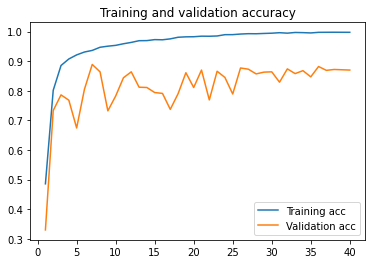

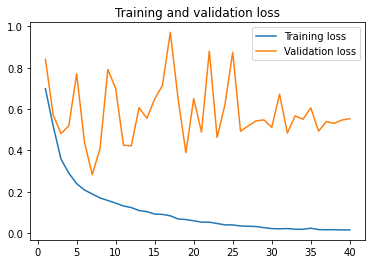

In [30]:
draw_train_graph(history)

In [38]:
model2.evaluate(x_test,y_test)

79/79 [==============================] - 8s 93ms/step - loss: 0.7828 - accuracy: 0.8226


[0.7827903628349304, 0.8225677609443665]

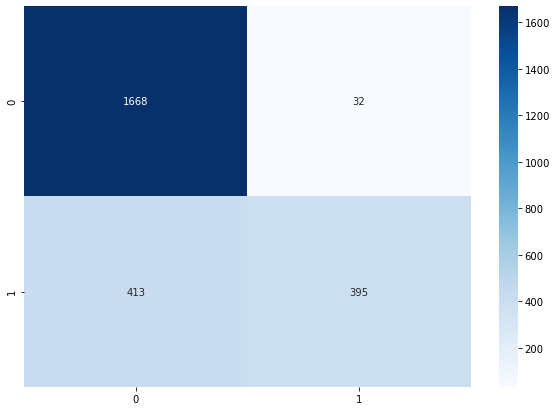

In [11]:
y_test_predict = draw_confusion_matrix(model1,x_test,y_test)

In [12]:
print_classification_report(y_test,  y_test_predict)

              precision    recall  f1-score   support

    abnormal       0.80      0.98      0.88      1700
      normal       0.93      0.49      0.64       808

    accuracy                           0.82      2508
   macro avg       0.86      0.74      0.76      2508
weighted avg       0.84      0.82      0.80      2508



In [37]:
model1.save('resnet50_model1_82')

INFO:tensorflow:Assets written to: resnet50_model1_82\assets


### try the model on oversampled data

In [11]:
train_path='D:/projects data/dataset/C-NMC_Leukemia/final/original/oversampled/'

In [12]:
train_generator ,valid_generator = create_generators(train_path)

Found 12224 images belonging to 2 classes.
Found 1358 images belonging to 2 classes.


In [22]:
model2=build_model()
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [23]:
history= train_model(model2 ,train_generator ,valid_generator)

Epoch 1/40
764/764 [==============================] - 207s 265ms/step - loss: 0.7050 - accuracy: 0.4669 - val_loss: 0.6391 - val_accuracy: 0.7003 - lr: 1.0000e-08
Epoch 2/40
764/764 [==============================] - 259s 339ms/step - loss: 0.4639 - accuracy: 0.8290 - val_loss: 0.2189 - val_accuracy: 0.9647 - lr: 1.0007e-05
Epoch 3/40
764/764 [==============================] - 204s 266ms/step - loss: 0.3174 - accuracy: 0.8937 - val_loss: 0.1804 - val_accuracy: 0.9543 - lr: 2.0003e-05
Epoch 4/40
764/764 [==============================] - 155s 202ms/step - loss: 0.2746 - accuracy: 0.9050 - val_loss: 0.1559 - val_accuracy: 0.9566 - lr: 3.0000e-05
Epoch 5/40
764/764 [==============================] - 154s 202ms/step - loss: 0.2323 - accuracy: 0.9188 - val_loss: 0.1620 - val_accuracy: 0.9492 - lr: 2.9946e-05
Epoch 6/40
764/764 [==============================] - 155s 203ms/step - loss: 0.2104 - accuracy: 0.9274 - val_loss: 0.2074 - val_accuracy: 0.9205 - lr: 2.9784e-05
Epoch 7/40
764/764 [==

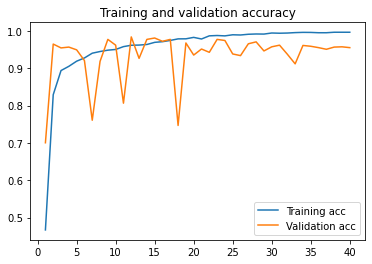

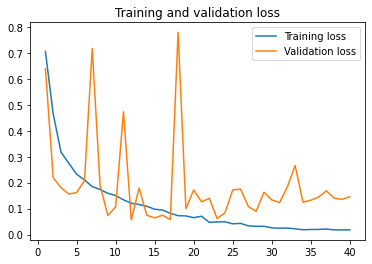

In [24]:
draw_train_graph(history)

In [36]:
model2.evaluate(x_test,y_test)

79/79 [==============================] - 8s 89ms/step - loss: 0.6809 - accuracy: 0.8070


[0.6809234619140625, 0.8070175647735596]

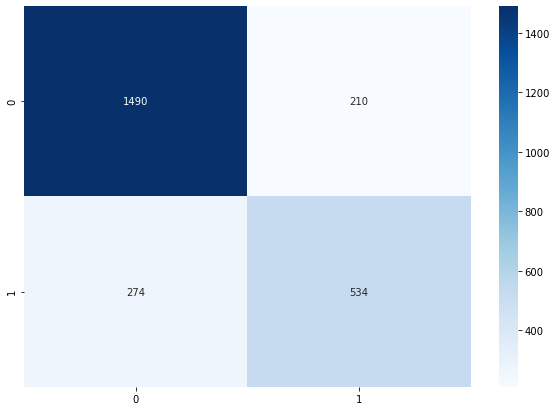

In [34]:
y_test_predict = draw_confusion_matrix(model2,x_test,y_test)

In [35]:
print_classification_report(y_test,  y_test_predict)

              precision    recall  f1-score   support

    abnormal       0.84      0.88      0.86      1700
      normal       0.72      0.66      0.69       808

    accuracy                           0.81      2508
   macro avg       0.78      0.77      0.77      2508
weighted avg       0.80      0.81      0.80      2508



In [37]:
model2.save('resnet50/Resnet50_model2_acc81.h5')

### try the model on undersampled data

In [43]:
train_path='D:/projects data/dataset/C-NMC_Leukemia/final/original/undersampled/'

In [44]:
train_generator,valid_generator = create_generators(train_path)

Found 5814 images belonging to 2 classes.
Found 644 images belonging to 2 classes.


In [8]:
plt.imread('D:/projects data/dataset/C-NMC_Leukemia/final/original/oversampled/abnormal/3389.bmp').max()

137

In [45]:
model3=build_model()
model3.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [46]:
history= train_model(model3 ,train_generator ,valid_generator)

Epoch 1/40
364/364 [==============================] - 94s 246ms/step - loss: 0.6911 - accuracy: 0.5146 - val_loss: 0.6936 - val_accuracy: 0.4938 - lr: 1.0000e-08
Epoch 2/40
364/364 [==============================] - 87s 239ms/step - loss: 0.5413 - accuracy: 0.7728 - val_loss: 0.6616 - val_accuracy: 0.6242 - lr: 1.0007e-05
Epoch 3/40
364/364 [==============================] - 74s 202ms/step - loss: 0.3811 - accuracy: 0.8586 - val_loss: 0.9851 - val_accuracy: 0.5016 - lr: 2.0003e-05
Epoch 4/40
364/364 [==============================] - 75s 206ms/step - loss: 0.3356 - accuracy: 0.8811 - val_loss: 0.8233 - val_accuracy: 0.5947 - lr: 3.0000e-05
Epoch 5/40
364/364 [==============================] - 89s 243ms/step - loss: 0.2793 - accuracy: 0.9033 - val_loss: 0.7825 - val_accuracy: 0.6289 - lr: 2.9946e-05
Epoch 6/40
364/364 [==============================] - 89s 244ms/step - loss: 0.2579 - accuracy: 0.9143 - val_loss: 0.4744 - val_accuracy: 0.7873 - lr: 2.9784e-05
Epoch 7/40
364/364 [========

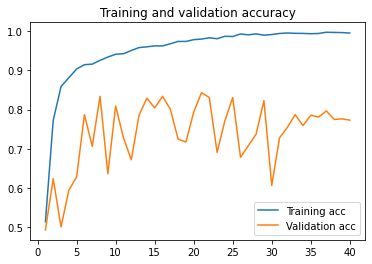

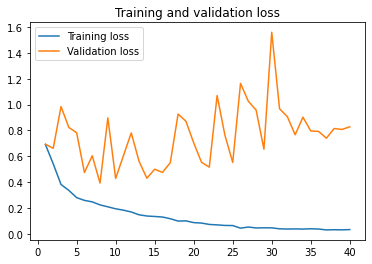

In [47]:
draw_train_graph(history)

In [14]:
model3.evaluate(x_test,y_test)

79/79 [==============================] - 9s 99ms/step - loss: 0.6613 - accuracy: 0.8174


[0.6612728238105774, 0.8173843622207642]

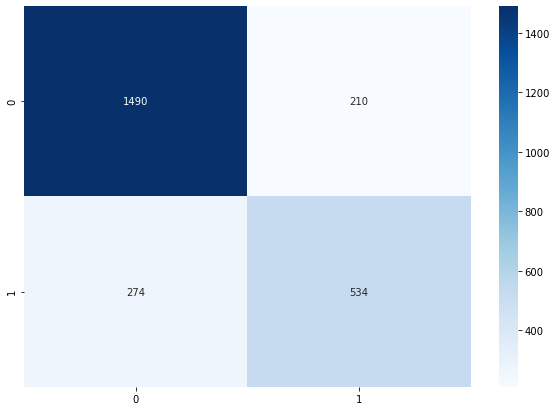

In [51]:
y_test_predict = draw_confusion_matrix(model2,x_test,y_test)

In [52]:
print_classification_report(y_test,  y_test_predict)

              precision    recall  f1-score   support

    abnormal       0.84      0.88      0.86      1700
      normal       0.72      0.66      0.69       808

    accuracy                           0.81      2508
   macro avg       0.78      0.77      0.77      2508
weighted avg       0.80      0.81      0.80      2508



In [54]:
model3.save('resnet50/Resnet50_model3_acc81.h5')

<a name="4"></a>
##  <span style="color:blue"> **train the model on the paper preprocessed data** </span>

<a name="4.1"></a>

### the model on preprocessed imbalanced data

In [56]:
train_path='D:/projects data/dataset/C-NMC_Leukemia/final/paper preprocessed/imbalanced/'

In [57]:
train_generator,valid_generator = create_generators(train_path)

Found 9019 images belonging to 2 classes.
Found 1001 images belonging to 2 classes.


<a name="2"></a>

#### build the model

In [60]:
model4=build_model()

model4.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

<a name="2.1"></a>

### model complie & train

In [61]:
history=train_model(model4,train_generator,valid_generator)

Epoch 1/40
564/564 [==============================] - 411s 722ms/step - loss: 0.6911 - accuracy: 0.5352 - val_loss: 0.6874 - val_accuracy: 0.6294 - lr: 1.0000e-08
Epoch 2/40
564/564 [==============================] - 126s 223ms/step - loss: 0.5663 - accuracy: 0.7638 - val_loss: 0.6626 - val_accuracy: 0.6803 - lr: 1.0007e-05
Epoch 3/40
564/564 [==============================] - 128s 227ms/step - loss: 0.4592 - accuracy: 0.8199 - val_loss: 0.5014 - val_accuracy: 0.7782 - lr: 2.0003e-05
Epoch 4/40
564/564 [==============================] - 115s 202ms/step - loss: 0.4118 - accuracy: 0.8401 - val_loss: 0.5100 - val_accuracy: 0.7662 - lr: 3.0000e-05
Epoch 5/40
564/564 [==============================] - 130s 231ms/step - loss: 0.3751 - accuracy: 0.8508 - val_loss: 0.4138 - val_accuracy: 0.8322 - lr: 2.9946e-05
Epoch 6/40
564/564 [==============================] - 115s 203ms/step - loss: 0.3581 - accuracy: 0.8565 - val_loss: 0.4093 - val_accuracy: 0.8202 - lr: 2.9784e-05
Epoch 7/40
564/564 [==

<a name="2.2"></a>

### train & validation loss and accuracy per epochs

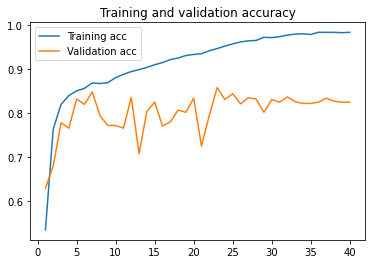

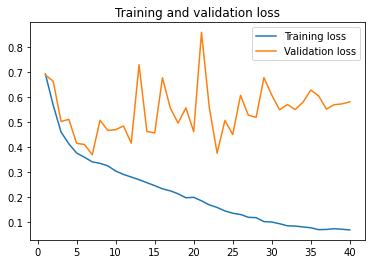

In [62]:
draw_train_graph(history)

In [70]:
model4.evaluate(x_test,y_test)

79/79 [==============================] - 8s 92ms/step - loss: 1.1657 - accuracy: 0.7077


[1.165661334991455, 0.7077352404594421]

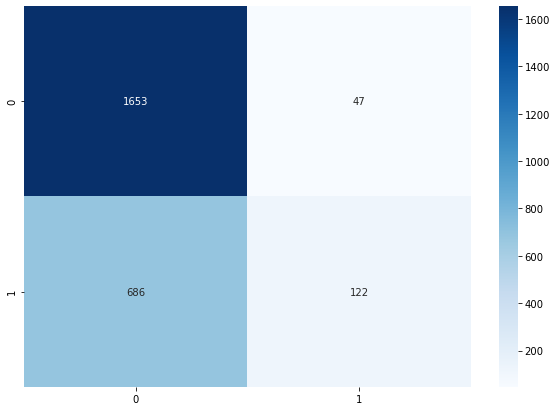

In [68]:
y_test_predict = draw_confusion_matrix(model4,x_test,y_test)

In [69]:
print_classification_report(y_test,  y_test_predict)

              precision    recall  f1-score   support

    abnormal       0.71      0.97      0.82      1700
      normal       0.72      0.15      0.25       808

    accuracy                           0.71      2508
   macro avg       0.71      0.56      0.53      2508
weighted avg       0.71      0.71      0.64      2508



In [71]:
model4.save('resnet50/Resnet50_model4_acc71.h5')

<a name="4.2"></a>

### the model on preprocessed oversampled data

In [14]:
train_path='D:/projects data/dataset/C-NMC_Leukemia/final/paper preprocessed/oversampled/'

In [15]:
train_generator,valid_generator = create_generators(train_path)

Found 10866 images belonging to 2 classes.
Found 2716 images belonging to 2 classes.


<a name="2"></a>

### build the model

In [16]:
model5=build_model()

model5.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

<a name="2.1"></a>

### model complie & train

In [17]:
history=train_model(model5,train_generator,valid_generator)

Epoch 1/40
680/680 [==============================] - 515s 744ms/step - loss: 0.7083 - accuracy: 0.4590 - val_loss: 0.7247 - val_accuracy: 0.4168 - lr: 1.0000e-08
Epoch 2/40
680/680 [==============================] - 154s 225ms/step - loss: 0.4934 - accuracy: 0.7999 - val_loss: 0.3245 - val_accuracy: 0.9120 - lr: 1.0007e-05
Epoch 3/40
680/680 [==============================] - 141s 207ms/step - loss: 0.3886 - accuracy: 0.8490 - val_loss: 0.3672 - val_accuracy: 0.8461 - lr: 2.0003e-05
Epoch 4/40
680/680 [==============================] - 142s 209ms/step - loss: 0.3537 - accuracy: 0.8620 - val_loss: 0.4117 - val_accuracy: 0.7887 - lr: 3.0000e-05
Epoch 5/40
680/680 [==============================] - 156s 229ms/step - loss: 0.3220 - accuracy: 0.8759 - val_loss: 0.2205 - val_accuracy: 0.9264 - lr: 2.9946e-05
Epoch 6/40
680/680 [==============================] - 142s 208ms/step - loss: 0.3025 - accuracy: 0.8869 - val_loss: 0.2636 - val_accuracy: 0.8895 - lr: 2.9784e-05
Epoch 7/40
680/680 [==

<a name="2.2"></a>

### train & validation loss and accuracy per epochs

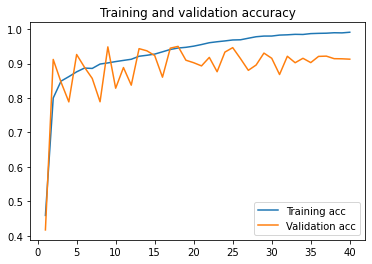

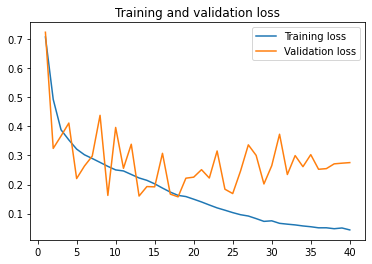

In [18]:
draw_train_graph(history)

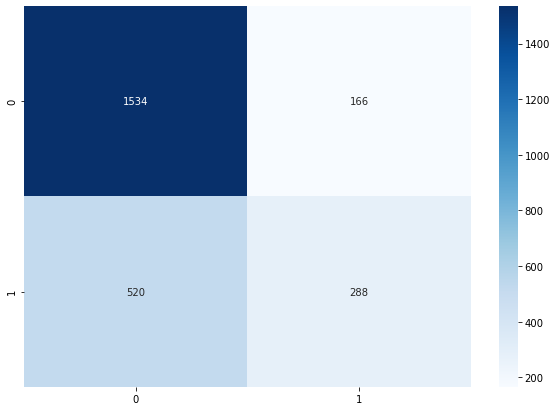

In [21]:
y_test_predict = draw_confusion_matrix(model5,x_test,y_test)

In [22]:
print_classification_report(y_test,  y_test_predict)

              precision    recall  f1-score   support

    abnormal       0.75      0.90      0.82      1700
      normal       0.63      0.36      0.46       808

    accuracy                           0.73      2508
   macro avg       0.69      0.63      0.64      2508
weighted avg       0.71      0.73      0.70      2508



In [27]:
model5.evaluate(x_test,y_test)

79/79 [==============================] - 8s 91ms/step - loss: 1.0225 - accuracy: 0.7265


[1.022504448890686, 0.7264752984046936]

In [26]:
model5.save('resnet50/Resnet50_model5_acc73.h5')

<a name="4.3"></a>

### the model on undersampled preprocessed data

In [28]:
train_path='D:/projects data/dataset/C-NMC_Leukemia/final/paper preprocessed/undersampled/'

In [32]:
train_generator ,valid_generator = create_generators(train_path)

Found 5168 images belonging to 2 classes.
Found 1290 images belonging to 2 classes.


In [40]:
plt.imread('D:/projects data/dataset/C-NMC_Leukemia/final/original/oversampled/abnormal/3389.bmp').max(),

137

In [30]:
model6=build_model()
model6.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [33]:
history= train_model(model6 ,train_generator ,valid_generator)

Epoch 1/40
323/323 [==============================] - 217s 658ms/step - loss: 0.7023 - accuracy: 0.4805 - val_loss: 0.6939 - val_accuracy: 0.4031 - lr: 1.0000e-08
Epoch 2/40
323/323 [==============================] - 82s 252ms/step - loss: 0.6177 - accuracy: 0.6966 - val_loss: 0.7059 - val_accuracy: 0.4961 - lr: 1.0007e-05
Epoch 3/40
323/323 [==============================] - 82s 251ms/step - loss: 0.5123 - accuracy: 0.7719 - val_loss: 0.6232 - val_accuracy: 0.6891 - lr: 2.0003e-05
Epoch 4/40
323/323 [==============================] - 68s 210ms/step - loss: 0.4748 - accuracy: 0.7831 - val_loss: 0.6482 - val_accuracy: 0.6225 - lr: 3.0000e-05
Epoch 5/40
323/323 [==============================] - 67s 208ms/step - loss: 0.4574 - accuracy: 0.7949 - val_loss: 0.7290 - val_accuracy: 0.6194 - lr: 2.9946e-05
Epoch 6/40
323/323 [==============================] - 83s 256ms/step - loss: 0.4438 - accuracy: 0.8055 - val_loss: 0.4166 - val_accuracy: 0.8186 - lr: 2.9784e-05
Epoch 7/40
323/323 [=======

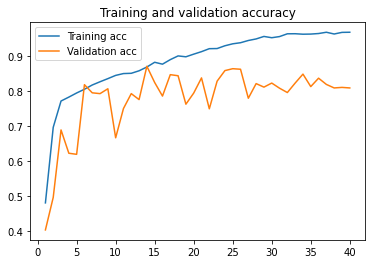

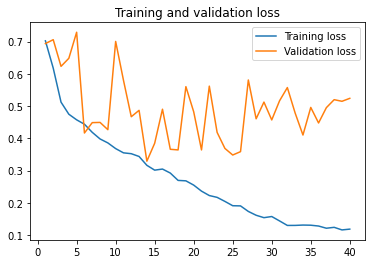

In [35]:
draw_train_graph(history)

In [36]:
model6.evaluate(x_test,y_test)

79/79 [==============================] - 8s 97ms/step - loss: 0.7252 - accuracy: 0.7444


[0.7252041697502136, 0.7444178462028503]

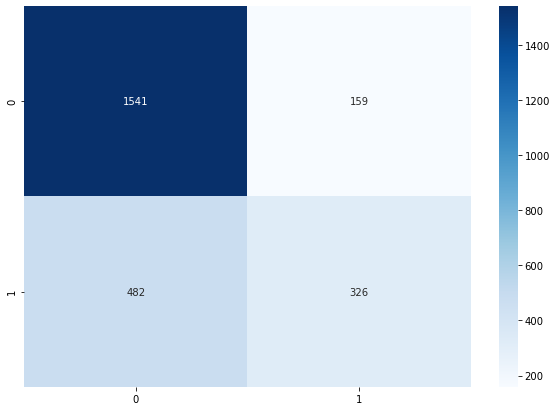

In [40]:
y_test_predict = draw_confusion_matrix(model6,x_test,y_test)

In [41]:
print_classification_report(y_test,  y_test_predict)

              precision    recall  f1-score   support

    abnormal       0.76      0.91      0.83      1700
      normal       0.67      0.40      0.50       808

    accuracy                           0.74      2508
   macro avg       0.72      0.65      0.67      2508
weighted avg       0.73      0.74      0.72      2508



In [38]:
model6.save('resnet50/Resnet50_model6_acc74.h5')